# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [90]:
import pandas as pd

In [91]:
data = pd.read_csv('train.csv')

In [92]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [93]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5329 entries, 1186 to 7270
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5329 non-null   int64 
 1   keyword   5285 non-null   object
 2   location  3569 non-null   object
 3   text      5329 non-null   object
 4   target    5329 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 249.8+ KB


In [95]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2284 entries, 2644 to 6753
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2284 non-null   int64 
 1   keyword   2267 non-null   object
 2   location  1511 non-null   object
 3   text      2284 non-null   object
 4   target    2284 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 107.1+ KB


Колонка Non-null count показывает количество ненулевых строк. Колонки keyword и location имеют пропуски в train и в test, заполним их

In [96]:
train = train.fillna("")
test = test.fillna("")

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

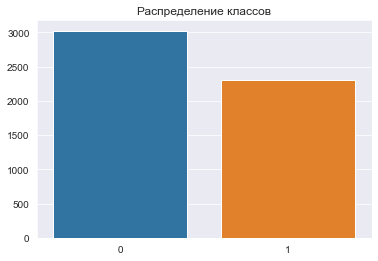

In [98]:
target_cnt = train['target'].value_counts()
sns.barplot(x=target_cnt.index, y=target_cnt.values)
plt.title('Распределение классов')
plt.show()

Классы распределены неравномерно, класса со значением "0" больше

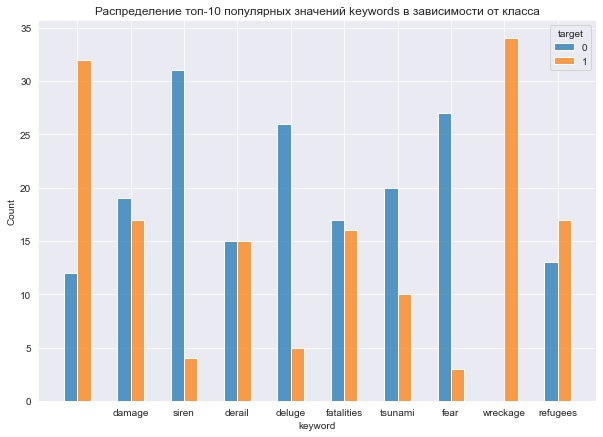

In [99]:
keyword_10_best = train['keyword'].value_counts()[:10].index
train['is_10best'] = train['keyword'].apply(lambda x: x in keyword_10_best)

plt.figure(figsize=(10, 7))
sns.histplot(x='keyword', hue='target', data=train[train['is_10best'] == 1], multiple="dodge", shrink=0.5)
plt.xticks(keyword_10_best)
plt.title('Распределение топ-10 популярных значений keywords в зависимости от класса')
plt.show()

In [100]:
train.drop('is_10best', axis=1, inplace=True)

Чаще всего keyword оказался пустым, причем преимущественно у 1 класса. Одни из самых высоких скачков у siren, deluge, fear - эти слова говорят о том, что твит не о настоящей катастрофе. И наоборот, wreckage встречается только в твитах с реальными катастрофами

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [101]:
train['all_text'] = train['keyword'] + ' ' + train['text'] + ' ' + train['location']
test['all_text'] = test['keyword'] + ' ' + test['text'] + ' ' + test['location']
train.drop(['location', 'text', 'keyword', 'id'], axis=1, inplace=True)
test.drop(['location', 'text', 'keyword', 'id'], axis=1, inplace=True)

In [102]:
train

,target,all_text
1186,0,bridge%20collapse Ashes 2015: AustraliaÛªs co...
4071,1,hail GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS...
5461,1,police CNN: Tennessee movie theater shooting s...
5787,1,rioting Still rioting in a couple of hours lef...
7445,0,wounds Crack in the path where I wiped out thi...
...,...,...
5226,0,obliteration @Eganator2000 There aren't many O...
5390,0,panic just had a panic attack bc I don't have ...
860,0,blood Omron HEM-712C Automatic Blood Pressure ...
7603,1,Officials say a quarantine is in place at an ...


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [103]:
from sklearn.feature_extraction.text import CountVectorizer

Преобразуем train часть:

In [104]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train['all_text'])

посмотрми размер:

In [105]:
X

<5329x18455 sparse matrix of type '<class 'numpy.int64'>'
	with 86671 stored elements in Compressed Sparse Row format>

5329 в данном случае это количество наших строк, а 18455 - количество уникальных слов в нашей обучающей выборке. Проверим:

In [106]:
len(vectorizer.vocabulary_)

18455

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [107]:
import re

In [108]:
def contain_digits(word: str):
    """
    Проверяет, содержит ли слово цифры
    """
    return bool(re.findall(r'[0-9]', word))

def contain_punc(word: str):
    """
    Проверяет, содержит ли слово пунктуацию
    """
    return bool(re.findall(r'[!"#\$%&\'\(\)\*\+,-\.\/:;<=>\?@\[\]\^_`{\|}~]', word))

def is_hashtag_ref(word: str):
    """
    Проверяет, является ли слово упоминанием или хэштегом
    """
    return word[0] == '#' or word[0] == '@'

In [109]:
def info_vocab(vocab: list):
    print(f"Всего слов: {len(vocab)}")
    words_with_digits = [word for word in vocab if contain_digits(word)]
    print(f"Слова, которые содержат цифры: {words_with_digits[:10]}")
    print(f"Количество слов, которые содержат цифры: {len(words_with_digits)}")

    words_with_punc = [word for word in vocab if contain_punc(word)]
    print(f"Слова, которые содержат пунктуацию: {words_with_punc[:10]}")
    print(f"Количество слов, которые содержат пунктуацию: {len(words_with_punc)}")

    print(f"Количество хэштегов и упоминаний в словаре: {len([word for word in vocab if is_hashtag_ref(word)])}")

In [110]:
info_vocab(vectorizer.vocabulary_.keys())

Всего слов: 18455
Слова, которые содержат цифры: ['20collapse', '2015', '60', 't5trhjuau0', 'b1g', 'bmurph1019', 'termn8r13', 'oaskgki6qj', 'di8elzswnr', '20accident']
Количество слов, которые содержат цифры: 3812
Слова, которые содержат пунктуацию: ['hail_youtsey', 'û_', '_gaabyx', 'early__may', 'til_now', 'marc_holl', 'mathew_is_angry', 'z3ke_sk1', 'derailed_benchmark', 'chubbysquirrel_']
Количество слов, которые содержат пунктуацию: 315
Количество хэштегов и упоминаний в словаре: 0


Хештегов и упоминаний в нашем словаре не осталось

## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [111]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

vectorizer = CountVectorizer(tokenizer=TweetTokenizer().tokenize)
X = vectorizer.fit_transform(train['all_text'])

In [112]:
info_vocab(vectorizer.vocabulary_.keys())

Всего слов: 19669
Слова, которые содержат цифры: ['20collapse', '2015', '60', 'http://t.co/t5trhjuau0', 'b1g', '@bmurph1019', '@termn8r13', 'http://t.co/oaskgki6qj', 'http://t.co/di8elzswnr', '20accident']
Количество слов, которые содержат цифры: 3939
Слова, которые содержат пунктуацию: ['%', ':', '...', 'http://t.co/t5trhjuau0', '@bmurph1019', '@hail_youtsey', '.', '@termn8r13', '#goblue', '#wrestleon']
Количество слов, которые содержат пунктуацию: 7336
Количество хэштегов и упоминаний в словаре: 3149


Слов стало больше. Добавились слова, состоящие только из знаков пунктуаций, ссылки, а также упоминания и хештеги.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [113]:
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\daris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [114]:
from nltk.corpus import stopwords

In [115]:
def is_smile(word: str):
    # если содержит только знаки пунктуации
    if re.fullmatch(r'[!"#\$%&\'\(\)\*\+,-\.\/:;<=>\?@\[\]\^_`{\|}~]+', word):
        # проверяем наличие скобок
        return bool(re.search(r'[\)\(]', word))

def is_hashtag(word: str):
    return re.match(r'#[A-Za-z]', word)

def tokenizer(text: str):
    # 0. Приведет все буквы к нижнему регистру
    small = text.lower()
    
    # 1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(small)

    # 2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены 
    # содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
    clear_tokens = [w for w in tokens if not re.search(r'[^A-Za-z]', w) or is_smile(w) or is_hashtag(w)]
    
    # 3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
    del_stopw = [w for w in clear_tokens if w not in stopwords.words('english')]

    # 4. Проведет стемминг с помощью SnowballStemmer
    stemmer = SnowballStemmer('russian')
    stemm_tokens = [stemmer.stem(w) for w in del_stopw]

    return stemm_tokens

In [116]:
tokens_10 = train['all_text'][:10].apply(tokenizer)
for p, f in zip(train['all_text'], tokens_10):
    print(f"До: {p} \nПосле: {f}")
    print()

До: bridge%20collapse Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0  
После: ['bridge', 'ashes', 'australia', 'collapse', 'trent', 'bridge', 'among', 'worst', 'history', 'england', 'bundled', 'australia']

До: hail GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
#GoBlue #WrestleOn http://t.co/OasKgki6Qj Carol Stream, Illinois 
После: ['hail', 'great', 'michigan', 'technique', 'camp', 'thanks', '#goblue', '#wrestleon', 'carol', 'stream', 'illinois']

До: police CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR Houston  
После: ['police', 'cnn', 'tennessee', 'movie', 'theater', 'shooting', 'suspect', 'killed', 'police', 'houston']

До: rioting Still rioting in a couple of hours left until I have to be up for class.  
После: ['rioting', 'still', 'rioting', 'couple', 'hours', 'left', 'class']

До: wounds Crack in the path wher

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [117]:
vectorizer = CountVectorizer(tokenizer=tokenizer)
X_train = vectorizer.fit_transform(train['all_text'])
y_train = train['target']

In [118]:
X_test = vectorizer.transform(test['all_text'])
y_test = test['target']

In [119]:
X_train.shape, y_train.shape

((5329, 12935), (5329,))

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


reg = LogisticRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
f1_score(y_test, y_pred)

0.7447608812466416

In [121]:
scores = dict()
scores["CountVectorizer"] = f1_score(y_test, y_pred)

## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(tokenizer=tokenizer)
X_train = vectorizer.fit_transform(train['all_text'])
y_train = train['target']

In [123]:
X_train.shape

(5329, 12935)

In [124]:
X_test = vectorizer.transform(test['all_text'])
y_test = test['target']

In [125]:
reg = LogisticRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
f1_score(y_test, y_pred)

0.7353760445682451

In [126]:
scores["Tfid_simple"] = f1_score(y_test, y_pred)

Качество, к сожалению, ухудшилось. Теперь проверим поставив пороговое значение df 0.009

In [127]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer, max_df=0.009)
X_train = vectorizer.fit_transform(train['all_text'])
y_train = train['target']


Посмотрим сколько теперь признаков имеет наша обучающая выборка

In [128]:
X_train.shape

(5329, 12827)

In [129]:
X_test = vectorizer.transform(test['all_text'])
y_test = test['target']

Замерим качество

In [130]:
reg = LogisticRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
f1_score(y_test, y_pred)

0.7083333333333334

In [131]:
scores["Tfidf_change_max"] = f1_score(y_test, y_pred)

Качество оказалось еще хуже. Теперь изменим параметр min_df, который удалит слова со слишком маленьким df

In [132]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer, min_df=0.001, max_df=0.009)
X_train = vectorizer.fit_transform(train['all_text'])
y_train = train['target']

Посмотрим на размер обучающей выборки

In [133]:
X_train.shape

(5329, 1694)

Количество признаков сильно уменьшилось

In [134]:
X_test = vectorizer.transform(test['all_text'])
y_test = test['target']

In [135]:
reg = LogisticRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
f1_score(y_test, y_pred)

0.7015008337965536

In [136]:
scores["Tfidf_change_minmax"] = f1_score(y_test, y_pred)

Учитывая, что количество признаков в разы стало меньше, f1 score сильно не поменялась, хотя в целом упала

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [137]:
from sklearn.feature_extraction.text import HashingVectorizer

In [138]:
hv = HashingVectorizer(n_features=5000)
X_train = hv.transform(train['all_text'])
X_test = hv.transform(test['all_text'])

In [139]:
reg = LogisticRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
f1_score(y_test, y_pred)

0.7253481894150418

In [140]:
scores["HashingVectorizer"] = f1_score(y_test, y_pred)

Посмотрим какой векторизатор показал себя лучше всех

(0.6, 0.7819989253089737)

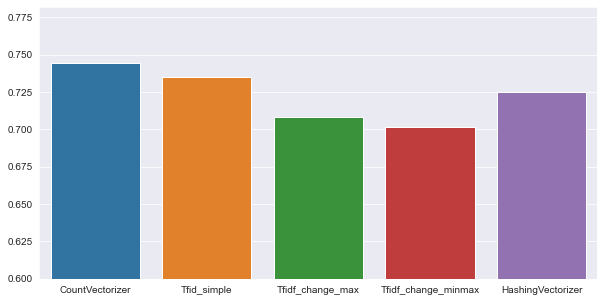

In [160]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.ylim(0.6)

Как оказалось, самый первый вариант является лучшим

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [168]:
vectorizer = CountVectorizer(tokenizer=tokenizer)
X_train = vectorizer.fit_transform(train['all_text'])
y_train = train['target']

X_test = vectorizer.transform(test['all_text'])

In [172]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

sgd_y_pred = sgd.predict(X_test)

In [174]:
f1_score(y_test, sgd_y_pred)

0.7514953779227841